In [5]:
import s3fs
import numcodecs as ncd
import numpy as np
import datetime
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fs = s3fs.S3FileSystem(anon=True)

In [6]:
#location: Example is Salt Lake City (SLC). Can only do coordinates in area that is covered by the HRRR CONUS grid.
point_lat = 40.7608
point_lon = -111.8910

# Date: [YYYYMMDD] must be in this format. Example is for Aug 21, 2024
date = '20240821'

# Hour: [00-23]z must be in the two digit format  i.e. 06 or 19
hr = '00'

# Level: 
level = 'surface'

# Variable:
var = 'TMP'

data_url = f'hrrrzarr/sfc/{date}/{date}_{hr}z_fcst.zarr/{level}/{var}/{level}/{var}/'

In [7]:
chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=fs))


In [8]:
import cartopy.crs as ccrs

# This is the projection the HRRR grid uses.
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

x, y = projection.transform_point(point_lon, point_lat, ccrs.PlateCarree())

nearest_point = chunk_index.sel(x=x, y=y, method="nearest")
fcst_chunk_id = f"0.{nearest_point.chunk_id.values}"
print(fcst_chunk_id)

0.4.3


In [9]:
%%time
def retrieve_data(s3_url):
    with fs.open(s3_url, 'rb') as compressed_data: # using s3fs
        buffer = ncd.blosc.decompress(compressed_data.read())

        dtype = "<f4" # See variables background page and python data loading
                      # guide for info on when you need a different dtype

        chunk = np.frombuffer(buffer, dtype=dtype)
        
        entry_size = 150*150
        num_entries = len(chunk)//entry_size

        if num_entries == 1: # analysis file is 2d
            data_array = np.reshape(chunk, (150, 150))
        else:
            data_array = np.reshape(chunk, (num_entries, 150, 150))

    return data_array


data = retrieve_data(data_url + fcst_chunk_id)
print(data.shape)


(48, 150, 150)
CPU times: user 29.4 ms, sys: 20.6 ms, total: 50 ms
Wall time: 587 ms


In [10]:
gridpoint_forecast = data[:, nearest_point.in_chunk_y, nearest_point.in_chunk_x]

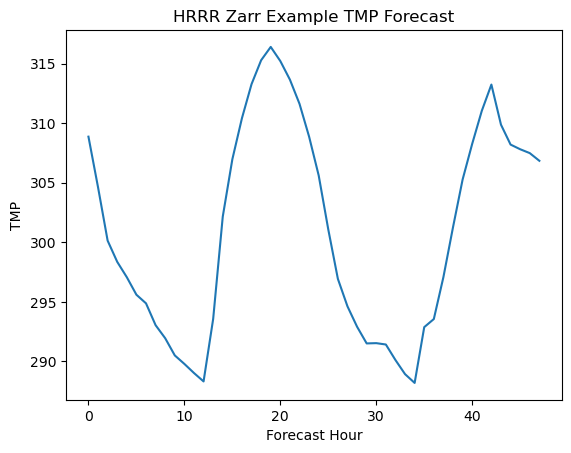

In [11]:
plt.title('HRRR Zarr Example %s Forecast' %(var))
plt.xlabel('Forecast Hour')
plt.ylabel(var)
plt.plot(gridpoint_forecast)

In [10]:
%%time
anl_chunk_id = nearest_point.chunk_id.values # doesn't have the 0.

start = datetime.datetime.strptime(date + hr, '%Y%m%d%H')
forecast_length = len(gridpoint_forecast)
gridpoint_analysis = []

for time_delta in range(forecast_length):
    # construct the aws path
    analysis_time = start + datetime.timedelta(hours=time_delta)
    url = analysis_time.strftime(f'hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_anl.zarr/{level}/{var}/{level}/{var}/{anl_chunk_id}')
    
    # download the chunk from s3
    hrrr_data_anl = retrieve_data(url)
    
    # append the data we need
    gridpoint_analysis.append(hrrr_data_anl[nearest_point.in_chunk_y, nearest_point.in_chunk_x])

CPU times: user 830 ms, sys: 128 ms, total: 958 ms
Wall time: 6.44 s


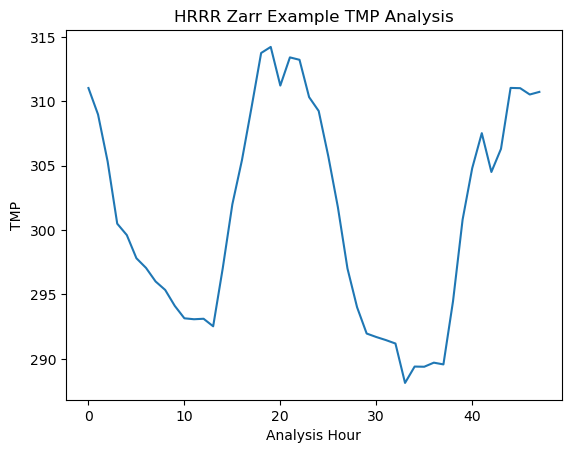

In [11]:
# Plot the data
plt.title('HRRR Zarr Example %s Analysis' %(var))
plt.xlabel('Analysis Hour')
plt.ylabel(var)
plt.plot(gridpoint_analysis)

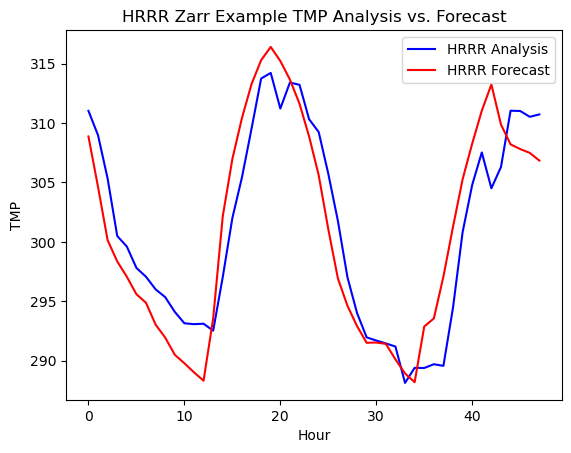

In [12]:
plt.title('HRRR Zarr Example %s Analysis vs. Forecast' %(var))
plt.xlabel('Hour')
plt.ylabel(var)
plt.plot(gridpoint_analysis, color='blue', label='HRRR Analysis')
plt.plot(gridpoint_forecast, color='red', label='HRRR Forecast')
plt.legend()